# Data Loader 만들기

In [2]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## Augmentation

In [3]:
%%capture 
!pip list | grep albumentations

In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

## Albumentation 적용

In [5]:
dir_path = '/content/drive/MyDrive/GD-CV/GD_04/data/training'

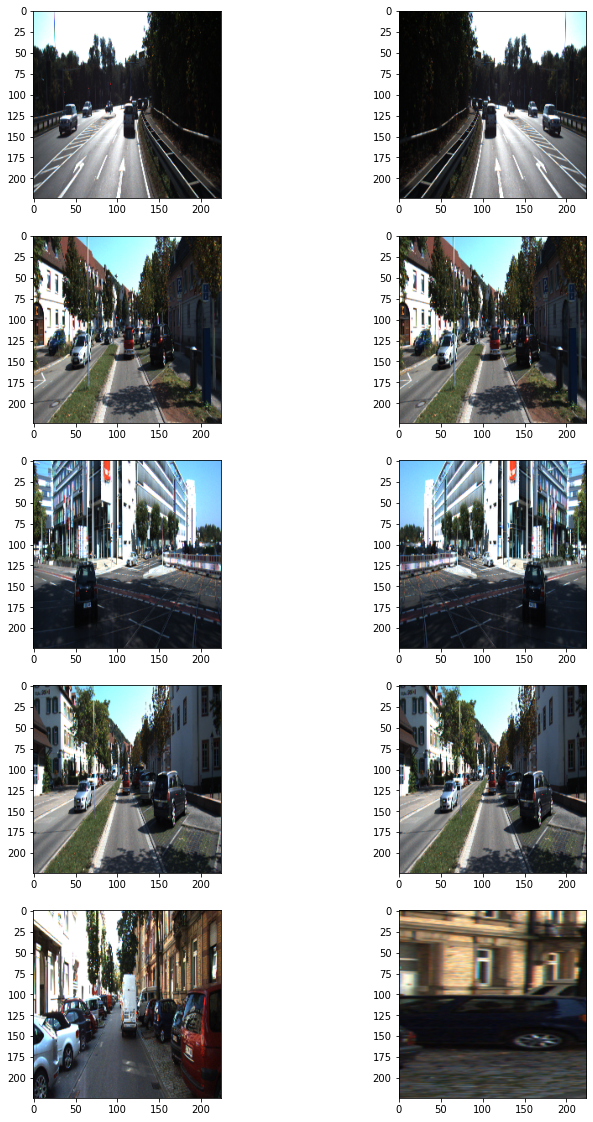

In [6]:
dir_path = '/content/drive/MyDrive/GD-CV/GD_04/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

# 데이터 셋 구성

In [7]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=10,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 모델 생성

 U-Net에 패딩을 적용하였습니다. 패딩을 적용하지 않고 구현해도 좋습니다.

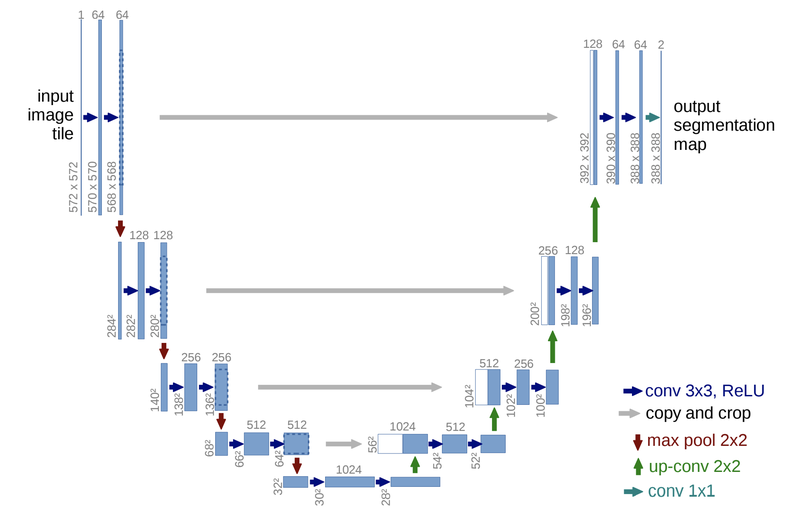

In [9]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)

  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)

  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  
  # skip할 때 dropout후의 정보를 전달
  drop4 = Dropout(0.5)(conv4)

  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  
  merge6 = concatenate([drop4,up6], axis = 3)
  
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)

  merge7 = concatenate([conv3,up7], axis = 3)

  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

모델 학습하기


In [ ]:
# model_path = '/content/drive/MyDrive/GD-CV/GD_04/seg_model_unet.h5'

# model = build_model()
# model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
# model.fit(
#      train_generator,
#      validation_data=test_generator,
#      steps_per_epoch=len(train_generator),
#      epochs=100,
#  )

# model.save(model_path)  #학습한 모델을 저장해 주세요.

In [10]:
model.summary()

NameError: ignored

In [ ]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [33]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 
# TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.

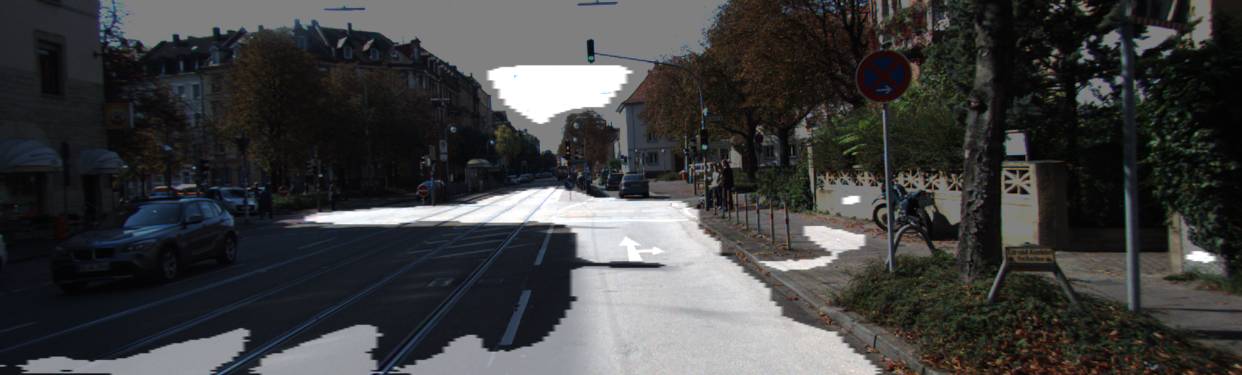

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [36]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

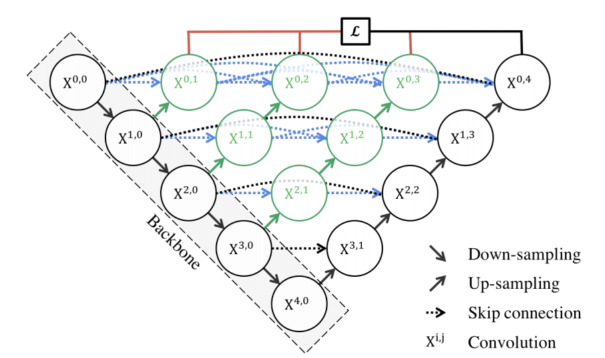

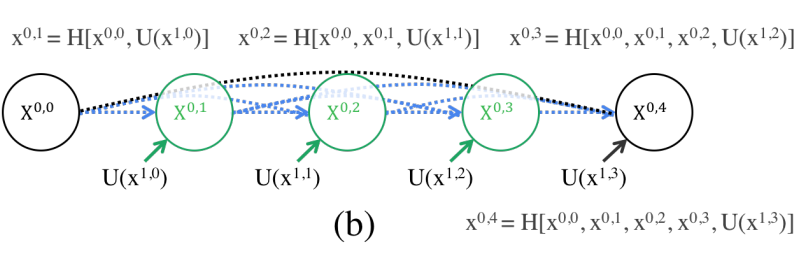

In [11]:
import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input, merge, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout

import numpy as np

In [12]:
smooth = 1.
dropout_rate = 0.5
act = "relu"

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

# Evaluation metric: IoU
def compute_iou(im1, im2):
    overlap = (im1>0.5) * (im2>0.5)
    union = (im1>0.5) + (im2>0.5)
    return overlap.sum()/float(union.sum())

# Evaluation metric: Dice
def compute_dice(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1>0.5).astype(np.bool)
    im2 = np.asarray(im2>0.5).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [39]:
def conv_block(inputs, channel):
    # inputs
    std_conv1 = Conv2D(channel, 3, activation='relu', padding='same')(inputs)
    batch_norm1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(std_conv1)
    std_conv2 = Conv2D(channel, 3, activation='relu', padding='same')(batch_norm1)
    batch_norm2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(std_conv2)
    return batch_norm2    

In [40]:
def build_model(input_shape=(224, 224, 3),num_class=1):
    # merge될 때 이전 sigma(pre-steps) + upsampled layer
    
    ch_list = [64, 128, 256, 512, 1024]
    inputs = Input(input_shape)
    num_class = num_class
    # 0_0
    conv00 = conv_block(inputs, ch_list[0])

    # 0_0 > 1_0
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv00)
    # conv1_0
    conv10 = conv_block(pool10,ch_list[1])
    # upsample 2 conv0_1
    up01 = Conv2DTranspose(ch_list[0], (2, 2), strides=(2, 2), padding='same')(conv10)
    #merge
    merge01 = concatenate([conv00,up01], axis = 3)
    conv01 = conv_block(merge01, ch_list[0])

    # 1_0 > 2_0
    pool20 = MaxPooling2D(pool_size=(2, 2))(conv10)

    # 2_0
    conv20 = conv_block(pool20,ch_list[2])

    up11 = Conv2DTranspose(ch_list[1], (2, 2), strides=(2, 2), padding='same')(conv20)
    merge11 = concatenate([conv10,up11], axis = 3)
    conv11 = conv_block(merge11, ch_list[1])

    # 2_0 > 3_0
    pool30 = MaxPooling2D(pool_size=(2, 2))(conv20)

    # 3_0
    conv30 = conv_block(pool30,ch_list[3])
    up21 = Conv2DTranspose(ch_list[2], (2, 2), strides=(2, 2), padding='same')(conv30)  
    merge21 = concatenate([conv20,up21], axis = 3)
    conv21 = conv_block(merge21, ch_list[2])

    # 3_0 > 4_0
    pool40 = MaxPooling2D(pool_size=(2, 2))(conv30)
    
    # 4_0
    conv40 = conv_block(pool40,ch_list[4]) 
    up31 = Conv2DTranspose(ch_list[3], (2, 2), strides=(2, 2), padding='same')(conv40)
    merge31 = concatenate([conv30,up31], axis = 3)
    conv31 = conv_block(merge31, ch_list[3])
    output31 = Conv2D(num_class,(1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv31)

    up02 = Conv2DTranspose(ch_list[0], (2, 2), strides=(2, 2), padding='same')(conv11)
    merge02 = concatenate([conv00,conv01, up02], axis = 3)
    conv02 = conv_block(merge02, ch_list[0])

    up12 = Conv2DTranspose(ch_list[1], (2, 2), strides=(2, 2), padding='same')(conv21)
    merge12 = concatenate([conv10,conv11,up12], axis = 3)
    conv12 = conv_block(merge12, ch_list[1])

    up22 = Conv2DTranspose(ch_list[2], (2, 2), strides=(2, 2), padding='same')(conv31)
    merge22 = concatenate([conv20,conv21,up22], axis = 3)

    conv22 = conv_block(merge22, ch_list[2]) 
    output22 = Conv2D(num_class,(1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv22)  

    up03 = Conv2DTranspose(ch_list[0], (2, 2), strides=(2, 2), padding='same')(conv12)
    merge03 = concatenate([conv00, conv01, conv02, up03], axis = 3)    
    conv03 = conv_block(merge03, ch_list[0])

    up13 = Conv2DTranspose(ch_list[1], (2, 2), strides=(2, 2), padding='same')(conv22)
    merge13 = concatenate([conv10,conv11,conv12,up13], axis = 3)    
    conv13 = conv_block(merge13, ch_list[1])
    output13 = Conv2D(num_class,(1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv13) 

    up04 = Conv2DTranspose(ch_list[0], (2, 2), strides=(2, 2), padding='same')(conv13)
    merge04 = concatenate([conv00, conv01, conv02, conv03,up04], axis = 3)

    conv04 = conv_block(merge04, ch_list[0])
    output04 = Conv2D(num_class,(1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv04)   

    model = Model(inputs=inputs, outputs=[output04])

    return model

In [41]:
model_path = '/content/drive/MyDrive/GD-CV/GD_04/seg_model_unet_plpl.h5'
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model = build_model()
model.compile(optimizer=adam, loss=[dice_coef_loss],metrics=[dice_coef])

In [42]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_150 (Conv2D)            (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_104 (Batch  (None, 224, 224, 64  256        ['conv2d_150[0][0]']             
 Normalization)                 )                                                           

In [43]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=[dice_coef_loss],metrics=[dice_coef])
hist = model.fit(train_generator, validation_data=test_generator,steps_per_epoch=len(train_generator),epochs=100)

Epoch 1/100
17/17 [==============================] - 25s 632ms/step - loss: 0.8813 - dice_coef: 0.1190 - val_loss: 0.9419 - val_dice_coef: 0.0583
Epoch 2/100
17/17 [==============================] - 10s 588ms/step - loss: 0.8538 - dice_coef: 0.1464 - val_loss: 0.9410 - val_dice_coef: 0.0593
Epoch 3/100
17/17 [==============================] - 10s 587ms/step - loss: 0.8333 - dice_coef: 0.1669 - val_loss: 0.9380 - val_dice_coef: 0.0622
Epoch 4/100
17/17 [==============================] - 10s 589ms/step - loss: 0.8116 - dice_coef: 0.1887 - val_loss: 0.9333 - val_dice_coef: 0.0670
Epoch 5/100
17/17 [==============================] - 10s 588ms/step - loss: 0.7627 - dice_coef: 0.2376 - val_loss: 0.9223 - val_dice_coef: 0.0779
Epoch 6/100
17/17 [==============================] - 10s 589ms/step - loss: 0.7702 - dice_coef: 0.2301 - val_loss: 0.9058 - val_dice_coef: 0.0945
Epoch 7/100
17/17 [==============================] - 10s 587ms/step - loss: 0.8225 - dice_coef: 0.1778 - val_loss: 0.8796 - 

In [44]:
model.save(model_path)

In [54]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [52]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 
# TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.

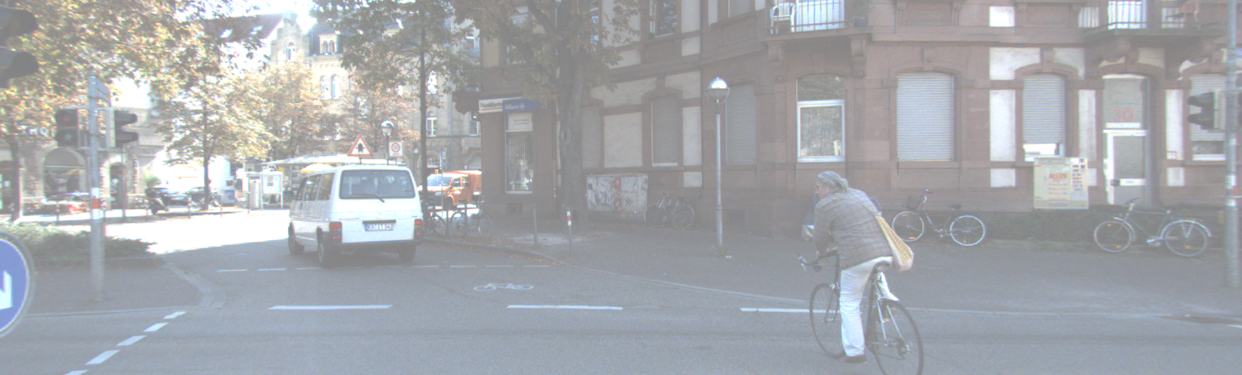

In [49]:
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [55]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.253448


0.25344786352040816

음... IoU 가 매우 낮다...

# 회고

이번에 U-Net++를 구현하는 project를 진행해보면서, U-Net과  skip Architecture를 어떻게 구현하는지에 대한 이해는 늘어났지만 막상 원하는 성능을 내기 위한 구현을 하기에는 실력이 턱없이 부족했다.

생각보다도 성능이 나오지 않았던 이유를 생각해봐야 할것 같다.